# Signal Process Identification and Verification of the interpolatable property of Parameterised Neural Networks

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns

Assigning the path of training data(without mass=1000), testing data(without mass=1000) and testing data with mass=1000.

---
The train_data_path contains data with masses from the set {500, 750, 1250, 1500}.

---
The test_data_path contains testing data with masses from the set {500, 750, 1250, 1500}.

---

The test1000_data_path contains data for mass=1000.

---
We shall train our Neural Network model only for the data with masses from the set {500, 750, 1250, 1500}. But as we shall see later on, when we test on data with mass=1000, our neural network model successfully interpolates and performs a good classification between collisions which produce new particles and collsions which do not.





In [2]:
# One can change the paths of the respective data if needed

train_data_path = '/content/drive/MyDrive/collision_data/not1000_train.csv.gz'
test_data_path = '/content/drive/MyDrive/collision_data/not1000_test.csv.gz'
test1000_data_path = '/content/drive/MyDrive/collision_data/1000_test.csv.gz'

Loading the training data as numpy array. The first row contains the column labels, hence it is skipped.

In [3]:
data = np.loadtxt(train_data_path, delimiter=',', skiprows=1, dtype=np.float32)
print(data.shape)

(7000000, 29)


Splitting the training data into features and labels

In [4]:
X_numpy = data[:, 1:]
y_numpy = data[:, 0]

Checking for the balance of the labels 0 and 1. As we can see, the label classes are pretty much balanced. The frequency of each label is nearly same.

In [5]:
(y_numpy == 1).sum() / y_numpy.shape[0]

0.5001255714285714

Furthur dividing the training data into two parts for training and validation. 20% of the training data is kept aside for validtion. We shall train on the remaining 80% of the data.

In [5]:
X_numpy_train, X_numpy_valid, y_numpy_train, y_numpy_valid = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=2)

In [7]:
X_numpy_train.shape

(5600000, 28)

There are in total 28 features. The last feature is the mass of the new particle produced for the collision sample data. All the 27 features except mass, are normalised. So we only need to scale the mass feature. We use sklearns's Standard Scaler to standard scale the mass feature.

In [8]:
mass_scaler = StandardScaler()

training_masses = X_numpy_train[:, 27].reshape(-1, 1)
validation_masses = X_numpy_valid[:, 27].reshape(-1, 1)

training_masses = mass_scaler.fit_transform(training_masses)
validation_masses = mass_scaler.transform(validation_masses)

X_numpy_train[:, 27] = training_masses.flatten()
X_numpy_valid[:, 27] = validation_masses.flatten()

Creating a custom Dataset class for training and validation. The train variable in the constructor acts as a flag. If True, then an instance of the training data will be returned. If False, then an instance of the validation data will be returned.

In [9]:
class CollisionData(Dataset):
    def __init__(self, train=True):
        self.n_samples = y_numpy_train.shape[0] if train else y_numpy_valid.shape[0]
        
        if train:
            self.X = torch.from_numpy(X_numpy_train)
            self.y = torch.from_numpy(y_numpy_train).view(self.n_samples, 1)
        else:
            self.X = torch.from_numpy(X_numpy_valid)
            self.y = torch.from_numpy(y_numpy_valid).view(self.n_samples, 1)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [10]:
collision_data = CollisionData()

In [11]:
len(collision_data)

5600000

Creating a custom model by inheriting from the superclass nn.Module. The constructor takes in a list of layers for the neural network. Upon calling forward, the input is forward propagated across all the layers. In the end the sigmoid activation is applied and the output is returned.

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        self.layers = layers
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return torch.sigmoid(out)

In [13]:
n_features = X_numpy.shape[1]

Defining the layers for our model, and creating an instance of the model with the same layers. The layers are:


1.   Linear Layer with 28 input neurons(number of features) and 128 output neurons.
2.   ReLU activation function.

1.   Linear Layer with 128 input neurons and 256 output neurons.
2.   ReLU activation function.

1.   Linear Layer with 256 input neurons and 1 output neuron.











In [14]:
layers = [nn.Linear(n_features, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 1)]
model = NeuralNetwork(layers)

The function below returns the set of all parameters in our model, which are essentially the weights in the linear layers. The derivative of loss with respect to these weights will be calculated in each iteration while training, and the weights will be updated accordingly.

In [15]:
def get_params(layers):
    params = []
    for layer in layers:
        params += layer.parameters()
    return params

We train our model by providing batches of training data with the batch size being 1000. Since we are performing binary classification, the loss function used is Binary Cross Entropy Loss. The optimiser being used is the stochastic gradient descent.

In [16]:
epochs = 10
learning_rate = 0.01
batch_size = 1000
criterion = nn.BCELoss()
optimiser = torch.optim.SGD(get_params(model.layers), lr=learning_rate)

Creating a DataLoader instance for the training data. It shall provide batches of training data one after the other for training.

In [19]:
train_loader = DataLoader(dataset = collision_data, batch_size=batch_size, shuffle=True)
total_iters = len(train_loader)

In [20]:
for epoch in range(epochs):
    for i, (features, true_labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, true_labels)

        optimiser.zero_grad() # We calculate new set of gradients for each iteration
        loss.backward()       # Calculate gradients
        optimiser.step()      # Update weights(parameters)

        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{epochs}. iter: {i+1}/{total_iters}. loss: {loss.item():.4f}')

epoch: 1/10. iter: 100/5600. loss: 0.5900
epoch: 1/10. iter: 200/5600. loss: 0.5367
epoch: 1/10. iter: 300/5600. loss: 0.4932
epoch: 1/10. iter: 400/5600. loss: 0.4593
epoch: 1/10. iter: 500/5600. loss: 0.4688
epoch: 1/10. iter: 600/5600. loss: 0.4324
epoch: 1/10. iter: 700/5600. loss: 0.4142
epoch: 1/10. iter: 800/5600. loss: 0.3884
epoch: 1/10. iter: 900/5600. loss: 0.3971
epoch: 1/10. iter: 1000/5600. loss: 0.3954
epoch: 1/10. iter: 1100/5600. loss: 0.4079
epoch: 1/10. iter: 1200/5600. loss: 0.4258
epoch: 1/10. iter: 1300/5600. loss: 0.3641
epoch: 1/10. iter: 1400/5600. loss: 0.3565
epoch: 1/10. iter: 1500/5600. loss: 0.4132
epoch: 1/10. iter: 1600/5600. loss: 0.3837
epoch: 1/10. iter: 1700/5600. loss: 0.3742
epoch: 1/10. iter: 1800/5600. loss: 0.3875
epoch: 1/10. iter: 1900/5600. loss: 0.3755
epoch: 1/10. iter: 2000/5600. loss: 0.3561
epoch: 1/10. iter: 2100/5600. loss: 0.3567
epoch: 1/10. iter: 2200/5600. loss: 0.4226
epoch: 1/10. iter: 2300/5600. loss: 0.3469
epoch: 1/10. iter: 2

Creating a Dataset instance for validation data.

In [21]:
valid_dataset = CollisionData(train=False)
len(valid_dataset)

1400000

Creating a DataLoader instance for validation data.

In [22]:
valid_loader = DataLoader(dataset = valid_dataset, batch_size=batch_size)

Forward propagation of the validation features to get the predicted probabilities(of signal process)

In [23]:
predicted_probabilities = []
y_valid = []
with torch.no_grad():
    for features, true_labels in valid_loader:
        predicted_probabilities += model(features)
        y_valid += true_labels

Each element in the list of predicted_probabilities and y_valid is a tensor. Therefore we extract the values out of the tensor using python's list comprehension.

In [24]:
predicted_probabilities = [p.item() for p in predicted_probabilities]
y_valid = [y.item() for y in y_valid]

Calculating the area under the Receiver Operating Characteristic curve (roc-auc curve) for the validation predictions.

In [25]:
roc_auc_score(y_valid, predicted_probabilities)

0.9376359861741399

Loading the test data with masses from the set {500, 750, 1250, 1500} as numpy array. The first row contains the labels so we skip it.

In [27]:
test_data = np.loadtxt(test_data_path, delimiter=',', skiprows=1, dtype=np.float32)
print(test_data.shape)

(3500000, 29)


Splitting the test data into features and labels.

In [28]:
X_test_numpy = test_data[:, 1:]
y_test_numpy = test_data[:, 0]

Scaling the mass feature of the test data using the standard scaler we defined for the training data.

In [29]:
test_masses = X_test_numpy[:, 27].reshape(-1,1)
test_masses = mass_scaler.transform(test_masses)
X_test_numpy[:, 27] = test_masses.flatten()

Creating a custom Dataset for test data.

In [30]:
class TestCollisionData(Dataset):
    def __init__(self):
        self.n_samples = y_test_numpy.shape[0]
        self.X = torch.from_numpy(X_test_numpy)
        self.y = torch.from_numpy(y_test_numpy).view(self.n_samples, 1)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

Creating an instance of the test dataset.

In [31]:
test_dataset = TestCollisionData()

Creating an instance of test loader for the test data. It shall provide test data in batches of size 1000.

In [32]:
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size)

Using our trained Neural Network model, we calculate the probabilities of signal processes for the test data. We provide one batch of test data at a time, and perform forward propagation on the batch to get the probabilities.

In [33]:
test_probabilities = []
y_test = []
with torch.no_grad():
    for features, true_labels in test_loader:
        test_probabilities += model(features)
        y_test += true_labels

Extracting the numerical values out of tensors from test_probabilities list and y_test list.

In [34]:
test_probabilities = [p.item() for p in test_probabilities]
y_test = [y.item() for y in y_test]

Calculating the area under the Receiver Operating Characteristic curve for the test predictions. Note that this test data contains data with the mass feature from the set {500, 750, 1250, 1500}.

In [35]:
roc_auc_score(y_test, test_probabilities)

0.9375304618898944

Now we load test data from the dataset with mass=1000. Our model was trained with data with masses from the set {500, 750, 1250, 1500}. It has never seen a data with mass=1000. But since our model is a Neural Network Classifier, it can successfully interpolate and make very good predictions of event processes from the test data with mass=1000.

In [38]:
test1000_data = np.loadtxt(test1000_data_path, delimiter=',', skiprows=1, dtype=np.float32)
print(test1000_data.shape)

(3500000, 28)


Splitting the test data into features and labels.

In [54]:
X_test1000_numpy = test1000_data[:, 1:]
y_test1000_numpy = test1000_data[:, 0]

It is explicitly mentioned that this test dataset is for data with mass=1000. So the mass feature is absent. Therefore we add a column of mass feature into the test features with the value as 1000. It is important because our model expects to see 28 features in the data including the mass feature.

In [55]:
X_test1000_numpy = np.column_stack((X_test1000_numpy, np.full(X_test1000_numpy.shape[0], 1000.0).astype(np.float32)))

Scaling the mass feature in the test data using the same standard scaler we defined for training data.

In [56]:
test1000_masses = X_test1000_numpy[:, 27].reshape(-1,1)
test1000_masses = mass_scaler.transform(test1000_masses)
X_test1000_numpy[:, 27] = test1000_masses.flatten()

Creating a custom Dataset class for the test data.

In [57]:
class Test1000CollisionData(Dataset):
    def __init__(self):
        self.n_samples = y_test1000_numpy.shape[0]
        self.X = torch.from_numpy(X_test1000_numpy)
        self.y = torch.from_numpy(y_test1000_numpy).view(self.n_samples, 1)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

Creating instances of test dataset and test dataset loader.

In [58]:
test1000_dataset = Test1000CollisionData()
test1000_loader = DataLoader(dataset = test1000_dataset, batch_size=batch_size)

Forward propagating the test features into our model to get the probabilities of an event process.

In [59]:
test1000_probabilities = []
y_test1000 = []
with torch.no_grad():
    for features, true_labels in test1000_loader:
        test1000_probabilities += model(features)
        y_test1000 += true_labels

Extracting the numerical values out the tensors from test1000_probabilities and y_test1000. 

In [60]:
test1000_probabilities = [p.item() for p in test1000_probabilities]
y_test1000 = [y.item() for y in y_test1000]

We now calculate the area under the Receiver Operating Characteristic curve (roc-auc curve) for the test data with the value of mass as 1000. Our model never saw a data with mass=1000. But since the model is a Neural Network Classifier, it successfully interpolates and makes very good predictions of signal processes. The area under the roc-auc curve obtained for test data with mass=1000 is 0.9692 which signifies a very good classification.

In [61]:
roc_auc_score(y_test1000, test1000_probabilities)

0.9692344399253425

Distribution plot of the scaled masses in training data.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


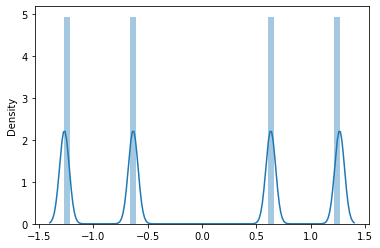

In [62]:
sns.distplot(X_numpy_train[:, 27])

Distribution plot of the scaled masses in the test data with mass=1000.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


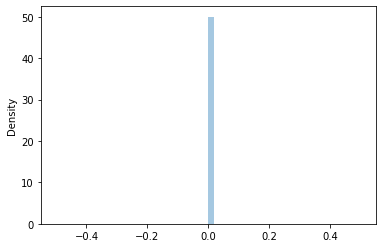

In [63]:
sns.distplot(X_test1000_numpy[:, 27])